In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime


In [2]:
from src.utils.metrics import obtener_ruta_app

In [3]:
df = pd.read_csv(os.path.join(obtener_ruta_app("AgroIA"), "data", "processed", "RNN", "rnn_produccion.csv"),index_col='fecha', parse_dates=True, date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))

C:\Users\pmari\AppData\Local\Temp\ipykernel_20856\3625814039.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(os.path.join(obtener_ruta_app("AgroIA"), "data", "processed", "RNN", "rnn_produccion.csv"),index_col='fecha', parse_dates=True, date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))


In [4]:
df.dtypes

produccion     float64
lluvia         float64
humedad        float64
temperatura    float64
dtype: object

In [5]:
df.head()

,produccion,lluvia,humedad,temperatura
fecha,,,,
2015-01-01,36.40,171.90,90.67,19.20
2015-02-01,62.20,107.62,89.37,19.11
2015-03-01,102.80,79.44,86.31,19.49
2015-04-01,29.95,115.93,85.46,20.80
2015-05-01,8.40,253.66,89.03,20.93


### Train

In [6]:
len(df)

126

In [7]:
tamaño_test = 18

In [8]:
test_ind = len(df)- tamaño_test

In [9]:
test_ind

108

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [11]:
train

,produccion,lluvia,humedad,temperatura
fecha,,,,
2015-01-01,36.400,171.90,90.67,19.20
2015-02-01,62.200,107.62,89.37,19.11
2015-03-01,102.800,79.44,86.31,19.49
2015-04-01,29.950,115.93,85.46,20.80
2015-05-01,8.400,253.66,89.03,20.93
...,...,...,...,...
2023-08-01,110.920,232.04,90.84,21.40
2023-09-01,75.360,177.24,88.68,21.45
2023-10-01,114.800,381.46,92.57,21.52


In [12]:
test

,produccion,lluvia,humedad,temperatura
fecha,,,,
2024-01-01,106.498,33.88,89.62,20.49
2024-02-01,78.050,117.35,87.47,20.06
2024-03-01,76.300,64.52,81.79,21.74
2024-04-01,23.240,171.48,83.24,21.64
2024-05-01,104.370,785.07,87.56,22.37
2024-06-01,66.010,768.48,92.91,21.82
2024-07-01,80.115,539.28,93.10,21.36
2024-08-01,64.680,201.52,90.32,21.32
2024-09-01,97.391,393.40,91.03,21.56


### Escalado

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Solo utilizamos train data para el ajuste del escalado, sino estaríamos asumiendo información acerca del conjunto de test
scaler.fit(train)

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [14]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

### Creación Generador Serie Temporal

In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


In [16]:
longitud = 12
tamaño_batch = 1
generador = TimeseriesGenerator(data=scaled_train, targets=scaled_train, length=longitud, batch_size=tamaño_batch)
X, y = generador[0]

In [17]:
print(f'Dado el array de entrada: \n{X.flatten()}')
print(f'Predecimos: \n {y}')

Dado el array de entrada: 
[0.21348552 0.27221493 0.76550681 0.13017751 0.36929674 0.15497556
 0.66717095 0.1035503  0.61448803 0.10357846 0.43570348 0.21597633
 0.17453272 0.17013205 0.37140696 0.6035503  0.04438808 0.42133581
 0.64145234 0.64201183 0.04016064 0.44891296 0.89939486 0.75147929
 0.10462904 0.40692712 0.88653555 0.53550296 0.36144578 0.26417159
 0.76248109 0.62130178 0.61388411 0.45394689 0.86686838 0.6183432
 0.55953136 0.49033341 0.81618759 0.70414201 0.3395537  0.43435836
 0.91981846 0.53550296 0.31578947 0.19535639 0.81013616 0.57988166]
Predecimos: 
 [[0.32400278 0.08285912 0.62027231 0.26923077]]


### Creación del Modelo

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [19]:

n_variables = scaled_train.shape[1] #Si hubiera múltiples variables cogeríamos el número de columnas: scaled_train.shape[1]
n_variables

4

In [20]:
# Definir modelo
model = Sequential()
model.add(LSTM(126, activation='relu', input_shape=(longitud, n_variables))) # Podemos aumentar el número de neuronas LSTM para intentar conseguir mayor precisión
model.add(Dense(n_variables)) #Solo 1 variable de salida, si hubiera múltiples variables indicaríamos tantas neuronas como variables
model.compile(optimizer='adam', loss='mse')

C:\Users\pmari\OneDrive\Para Revisar\Documentos\GitKraken\AgroIAPrincipal\AgroIA\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 126)            │        66,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           508 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,532 (259.89 KB)

 Trainable params: 66,532 (259.89 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
early_stop = EarlyStopping(monitor='val_loss',patience=30)

In [24]:
#Definimos generador para el conjunto de test de tal manera que nos sirva para la validación del modelo
val_generador = TimeseriesGenerator(scaled_test,scaled_test, length=longitud, batch_size=tamaño_batch)

In [25]:
model.fit(generador, epochs=300,
          validation_data=val_generador,
          callbacks=[early_stop])

Epoch 1/300


C:\Users\pmari\OneDrive\Para Revisar\Documentos\GitKraken\AgroIAPrincipal\AgroIA\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1272 - val_loss: 0.0669
Epoch 2/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0426 - val_loss: 0.0668
Epoch 3/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0410 - val_loss: 0.0416
Epoch 4/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0334 - val_loss: 0.0472
Epoch 5/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0315 - val_loss: 0.0522
Epoch 6/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0363 - val_loss: 0.0464
Epoch 7/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0279 - val_loss: 0.0696
Epoch 8/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0396 - val_loss: 0.0444
Epoch 9/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0245 - val_loss: 0.0480
Epoch 10/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0267 - val_loss: 0.0604
Epoch 11/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0368 - val_loss: 0.0460
Epoch 12/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0203 - val_lo

In [26]:
losses = pd.DataFrame(model.history.history)

<Axes: >

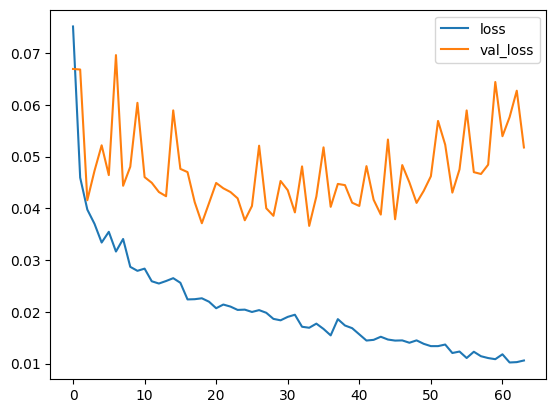

In [27]:
losses.plot()

### Evaluación del Modelo

In [28]:
primer_batch = scaled_train[-longitud:]

In [29]:
primer_batch.shape

(12, 4)

In [30]:
primer_batch = primer_batch.reshape((1, longitud, n_variables))

In [31]:
primer_batch.shape

(1, 12, 4)

In [32]:
model.predict(primer_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


array([[0.5239849 , 0.25596336, 0.7158513 , 0.23989707]], dtype=float32)

In [33]:
scaled_test[0]

array([0.63682097, 0.02048224, 0.68608169, 0.51183432])

In [34]:
test_predictions = []

primer_batch = scaled_train[-longitud:]
batch_actual = primer_batch.reshape((1, longitud, n_variables))

for i in range(len(test)):

    # Hacemos la predicción 1 time stamp (el siguiente mes). Indicar [0] para coger el valor de la predicción en lugar del array
    pred_actual = model.predict(batch_actual)[0]

    # Guardamos la predicción en la lista test_predictions
    test_predictions.append(pred_actual)

    # Actualizamos el batch para descartar el primer valor e incluir la nueva predicción (desplazamiento)
    batch_actual = np.append(batch_actual[:,1:,:],[[pred_actual]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [35]:
primer_batch

array([[0.4677658 , 0.10598599, 0.72995461, 0.13609467],
       [0.36968928, 0.1179142 , 0.57488654, 0.15680473],
       [0.43711689, 0.23517181, 0.52950076, 0.30177515],
       [0.26530181, 0.14523601, 0.21406959, 0.63017751],
       [0.18262524, 0.38017072, 0.37518911, 0.93786982],
       [0.32635806, 0.48987743, 0.75416036, 0.85207101],
       [0.39146058, 0.49354344, 0.85098336, 0.73076923],
       [0.66352629, 0.38190341, 0.77836611, 0.78106509],
       [0.44877253, 0.28195448, 0.61497731, 0.79585799],
       [0.68695836, 0.65442839, 0.90922844, 0.81656805],
       [1.        , 0.49538557, 1.        , 0.68639053],
       [0.41111816, 0.23234479, 0.83736762, 0.56213018]])

In [36]:
batch_actual

array([[[0.58036041, 0.53184378, 0.85132509, 0.49728081],
        [0.81988299, 0.44719094, 0.81109422, 0.52349257],
        [0.74254191, 0.57313812, 0.81738991, 0.55100518],
        [0.70261967, 0.50142741, 0.90694135, 0.41236225],
        [0.78963637, 0.31137991, 0.90546179, 0.30008459],
        [0.57571197, 0.25534537, 0.8026669 , 0.13328247],
        [0.41667503, 0.18670174, 0.660303  , 0.0024476 ],
        [0.52533543, 0.17373691, 0.50042462, 0.06347131],
        [0.63065267, 0.19518696, 0.34907711, 0.28145647],
        [0.45796537, 0.54767102, 0.46971732, 0.74372268],
        [0.29519323, 0.82767099, 0.86663938, 0.8787213 ],
        [0.62769341, 0.66474915, 1.018857  , 0.71886069]]])

In [37]:
#Desescalamos las predicciones para obtener los valores reales ("true_predictions")
true_predictions = scaler.inverse_transform(test_predictions)

In [38]:
true_predictions

array([[ 87.81404117, 162.98958845,  90.01355428,  19.5708521 ],
       [ 99.53202206, 152.67282831,  87.22189689,  19.37483679],
       [142.59324002, 128.87303753,  82.43565365,  20.24674912],
       [127.28837712, 278.81830123,  82.53926841,  21.68184697],
       [ 56.23040445, 476.53911216,  90.3308428 ,  21.74426345],
       [ 50.97888512, 457.08112541,  93.47610404,  20.8075064 ],
       [ 97.14897892, 314.24930851,  91.80451775,  20.44080913],
       [136.81032472, 267.83584879,  91.27266565,  20.5294049 ],
       [124.00380204, 336.89016722,  91.35589455,  20.62239752],
       [117.39327836, 297.57262147,  92.5397647 ,  20.1537844 ],
       [131.80193891, 193.37337679,  92.52020484,  19.77428592],
       [ 96.37926582, 162.65076185,  91.16125645,  19.21049474],
       [ 70.04513504, 125.01483264,  89.27920562,  18.76827288],
       [ 88.03766736, 117.90647575,  87.16561352,  18.97453303],
       [105.47662171, 129.66710518,  85.16479934,  19.71132287],
       [ 76.88219645, 322

In [39]:
for i in range(true_predictions.shape[1]):
    test[f'Predicción_{i+1}'] = true_predictions[:, i]

C:\Users\pmari\AppData\Local\Temp\ipykernel_20856\3603203859.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[f'Predicción_{i+1}'] = true_predictions[:, i]
C:\Users\pmari\AppData\Local\Temp\ipykernel_20856\3603203859.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[f'Predicción_{i+1}'] = true_predictions[:, i]
C:\Users\pmari\AppData\Local\Temp\ipykernel_20856\3603203859.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [40]:
test

,produccion,lluvia,humedad,temperatura,Predicción_1,Predicción_2,Predicción_3,Predicción_4
fecha,,,,,,,,
2024-01-01,106.498,33.88,89.62,20.49,87.814041,162.989588,90.013554,19.570852
2024-02-01,78.050,117.35,87.47,20.06,99.532022,152.672828,87.221897,19.374837
2024-03-01,76.300,64.52,81.79,21.74,142.593240,128.873038,82.435654,20.246749
2024-04-01,23.240,171.48,83.24,21.64,127.288377,278.818301,82.539268,21.681847
2024-05-01,104.370,785.07,87.56,22.37,56.230404,476.539112,90.330843,21.744263
2024-06-01,66.010,768.48,92.91,21.82,50.978885,457.081125,93.476104,20.807506
2024-07-01,80.115,539.28,93.10,21.36,97.148979,314.249309,91.804518,20.440809
2024-08-01,64.680,201.52,90.32,21.32,136.810325,267.835849,91.272666,20.529405
2024-09-01,97.391,393.40,91.03,21.56,124.003802,336.890167,91.355895,20.622398


<Axes: xlabel='fecha'>

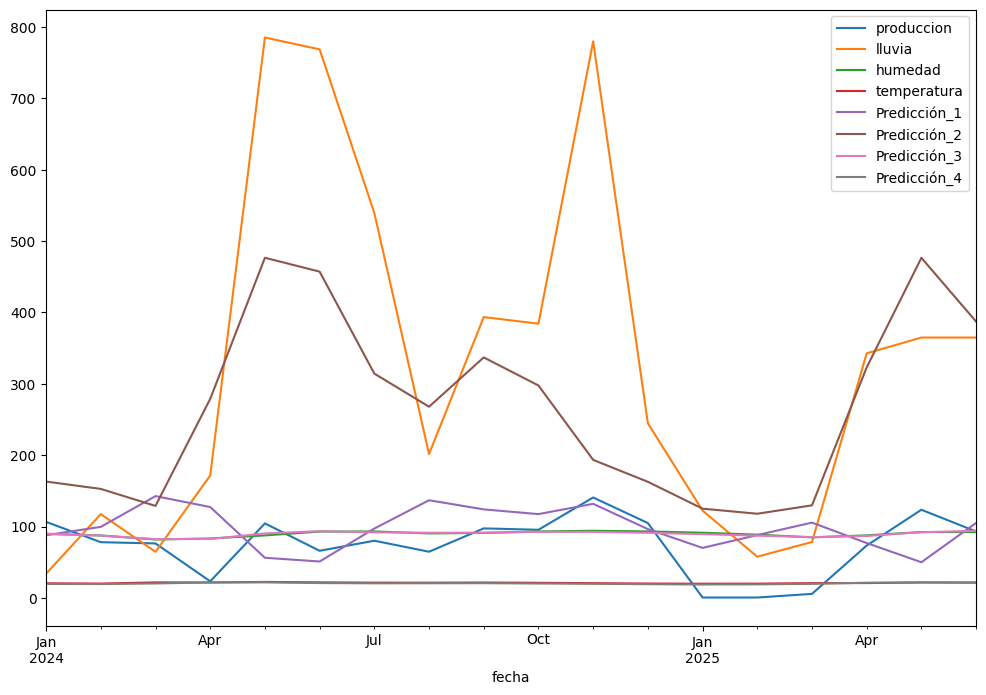

In [41]:
test.plot(figsize=(12,8))

In [42]:
from sklearn.metrics import mean_squared_error

In [43]:
col_real = 'produccion'  # o el nombre real de la columna con los valores verdaderos

for i in range(true_predictions.shape[1]):
    col_pred = f'Predicción_{i+1}'
    rmse = np.sqrt(mean_squared_error(test[col_real], test[col_pred]))
    print(f"RMSE para {col_pred} vs {col_real}: {rmse:.4f}")

RMSE para Predicción_1 vs produccion: 54.4828
RMSE para Predicción_2 vs produccion: 221.9510
RMSE para Predicción_3 vs produccion: 41.5898
RMSE para Predicción_4 vs produccion: 67.1394


In [44]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test['produccion'],test['Predicción_2']))

np.float64(221.9510426593464)

### Predicción de nuevos datos

In [45]:
df

,produccion,lluvia,humedad,temperatura
fecha,,,,
2015-01-01,36.400,171.90,90.67,19.20
2015-02-01,62.200,107.62,89.37,19.11
2015-03-01,102.800,79.44,86.31,19.49
2015-04-01,29.950,115.93,85.46,20.80
2015-05-01,8.400,253.66,89.03,20.93
...,...,...,...,...
2025-02-01,0.530,57.69,88.61,19.99
2025-03-01,5.640,78.32,84.79,20.68
2025-04-01,73.339,342.60,87.64,20.78


In [46]:
#Cogemos todos los datos originales y escalamos en base a ellos
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [47]:
longitud = 12 # Longitud de la secuencia de salida a predecir (en número de timesteps)
generador = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=longitud, batch_size=tamaño_batch)

In [48]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(longitud, n_variables)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Ajustamos el modelo, escogemos el número de epochs en base al entrenamiento anterior (no tiene sentido EarlyStopping puesto que no tenemos ahora datos de validación con los que comparar)
model.fit(generador,epochs=50)

Epoch 1/50


C:\Users\pmari\OneDrive\Para Revisar\Documentos\GitKraken\AgroIAPrincipal\AgroIA\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\pmari\OneDrive\Para Revisar\Documentos\GitKraken\AgroIAPrincipal\AgroIA\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1190
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0683
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0599
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0588
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0613
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0562
Epoch 7/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0539
Epoch 8/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0591
Epoch 9/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0599
Epoch 10/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0569
Epoch 11/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0618
Epoch 12/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0598
Epoch 13/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0569
Epoch 14/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0578
Epoch 15/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0555


In [49]:
forecast = []

periodos = 12 # Indicamos el número de periodos en base a la longitud del forecast deseada (12 meses)

primer_batch = scaled_full_data[-longitud:]
batch_actual = primer_batch.reshape((1, longitud, n_variables))

for i in range(periodos):

    pred_actual = model.predict(batch_actual)[0]
    forecast.append(pred_actual)

    # Actualizar batch_actual de forma más simple
    batch_actual = np.roll(batch_actual, -1, axis=1)
    batch_actual[0, -1, :] = pred_actual


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [50]:
batch_actual

array([[[0.59386265, 0.59386265, 0.59386265, 0.59386265],
        [0.5929535 , 0.5929535 , 0.5929535 , 0.5929535 ],
        [0.58441776, 0.58441776, 0.58441776, 0.58441776],
        [0.55727738, 0.55727738, 0.55727738, 0.55727738],
        [0.52810168, 0.52810168, 0.52810168, 0.52810168],
        [0.49040753, 0.49040753, 0.49040753, 0.49040753],
        [0.43328097, 0.43328097, 0.43328097, 0.43328097],
        [0.41721234, 0.41721234, 0.41721234, 0.41721234],
        [0.42499006, 0.42499006, 0.42499006, 0.42499006],
        [0.44803217, 0.44803217, 0.44803217, 0.44803217],
        [0.46403912, 0.46403912, 0.46403912, 0.46403912],
        [0.46634054, 0.46634054, 0.46634054, 0.46634054]]])

In [51]:
primer_batch


array([[0.47912465, 0.67761864, 0.93031875, 0.72022161],
       [0.3862015 , 0.23460822, 0.72424018, 0.70914127],
       [0.58313115, 0.48628053, 0.77687176, 0.77562327],
       [0.57128924, 0.47418746, 0.9273536 , 0.66204986],
       [0.8437374 , 0.99299599, 1.        , 0.52077562],
       [0.62809669, 0.29117809, 0.9340252 , 0.3767313 ],
       [0.        , 0.13070224, 0.79614529, 0.31301939],
       [0.        , 0.04595892, 0.59747961, 0.34072022],
       [0.03076367, 0.0730175 , 0.31430689, 0.53185596],
       [0.43833118, 0.41965059, 0.5255745 , 0.55955679],
       [0.74019446, 0.4486897 , 0.86730912, 0.7867036 ],
       [0.55712953, 0.4486897 , 0.86730912, 0.7867036 ]])

In [52]:
forecast

[array([0.59386265], dtype=float32),
 array([0.5929535], dtype=float32),
 array([0.58441776], dtype=float32),
 array([0.5572774], dtype=float32),
 array([0.5281017], dtype=float32),
 array([0.49040753], dtype=float32),
 array([0.43328097], dtype=float32),
 array([0.41721234], dtype=float32),
 array([0.42499006], dtype=float32),
 array([0.44803217], dtype=float32),
 array([0.46403912], dtype=float32),
 array([0.46634054], dtype=float32)]

In [53]:
# Usar los parámetros del scaler original solo para la primera variable
forecast = np.array(forecast)

# Extraer parámetros de la primera variable del scaler original
min_val = scaler.min_[0]
scale_val = scaler.scale_[0]

# Aplicar inverse transform manualmente
forecast_original = (forecast / scale_val) + min_val

In [54]:
forecast_original.shape[1]

1

In [55]:
forecast_original

array([[98.32840621],
       [98.17786466],
       [96.7644737 ],
       [92.27043405],
       [87.43937597],
       [81.19778912],
       [71.73848903],
       [69.07776371],
       [70.36563759],
       [74.1810658 ],
       [76.83157605],
       [77.21265747]])

In [56]:
forecast_variable_interes = forecast_original

In [57]:
forecast_original

array([[98.32840621],
       [98.17786466],
       [96.7644737 ],
       [92.27043405],
       [87.43937597],
       [81.19778912],
       [71.73848903],
       [69.07776371],
       [70.36563759],
       [74.1810658 ],
       [76.83157605],
       [77.21265747]])

### Creamos el nuevo índice de tiempos para el forecast

In [58]:
df

,produccion,lluvia,humedad,temperatura
fecha,,,,
2015-01-01,36.400,171.90,90.67,19.20
2015-02-01,62.200,107.62,89.37,19.11
2015-03-01,102.800,79.44,86.31,19.49
2015-04-01,29.950,115.93,85.46,20.80
2015-05-01,8.400,253.66,89.03,20.93
...,...,...,...,...
2025-02-01,0.530,57.69,88.61,19.99
2025-03-01,5.640,78.32,84.79,20.68
2025-04-01,73.339,342.60,87.64,20.78


In [59]:
#Creamos el índice para que empiece en el siguiente timestamp en el que acaban nuestros datos históricos
forecast_index = pd.date_range(start='2025-07-01',periods=periodos,freq='MS') #MS = Monthly Start

In [60]:
forecast_index

DatetimeIndex(['2025-07-01', '2025-08-01', '2025-09-01', '2025-10-01',
               '2025-11-01', '2025-12-01', '2026-01-01', '2026-02-01',
               '2026-03-01', '2026-04-01', '2026-05-01', '2026-06-01'],
              dtype='datetime64[ns]', freq='MS')

In [61]:
forecast_df = pd.DataFrame(data=forecast_variable_interes,index=forecast_index,
                           columns=['Forecast'])

In [62]:
forecast_df

,Forecast
2025-07-01,98.328406
2025-08-01,98.177865
2025-09-01,96.764474
2025-10-01,92.270434
2025-11-01,87.439376
2025-12-01,81.197789
2026-01-01,71.738489
2026-02-01,69.077764
2026-03-01,70.365638
2026-04-01,74.181066


<Axes: >

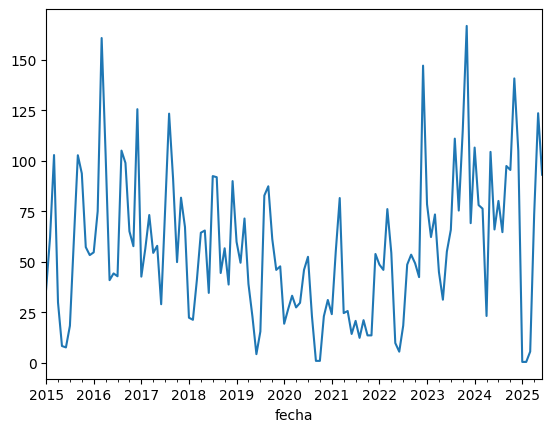

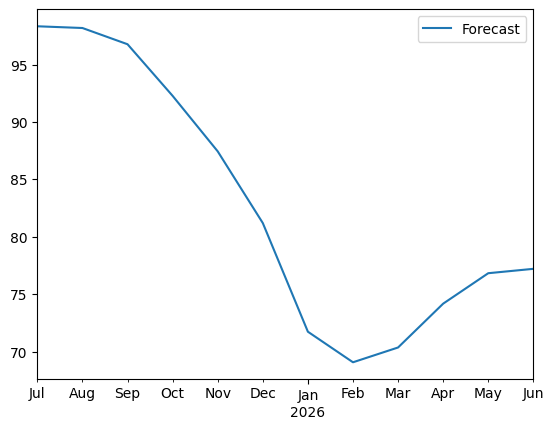

In [63]:
df['produccion'].plot()
forecast_df.plot()

<Axes: xlabel='fecha'>

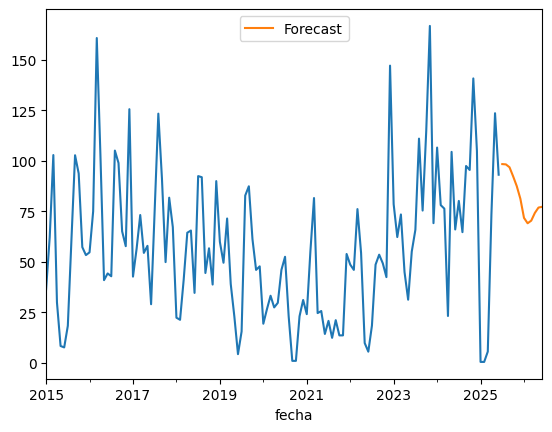

In [64]:
ax = df['produccion'].plot()
forecast_df.plot(ax=ax)

(663.0, 675.0)

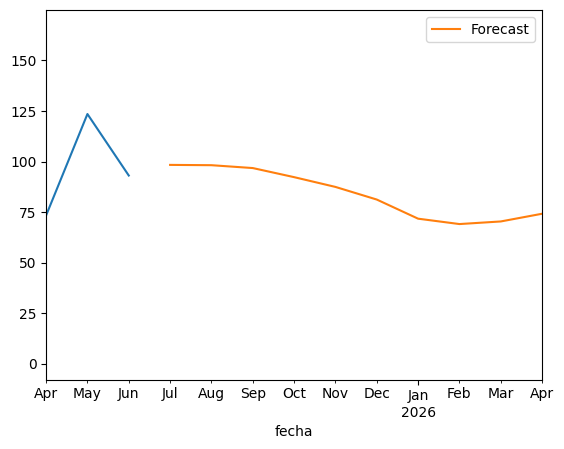

In [65]:
#Hacemos zoom
ax = df['produccion'].plot()
forecast_df.plot(ax=ax)
plt.xlim('2025-04-01','2026-04-01')

# Prueba con datos nuevos

In [66]:
df_prueba = pd.read_csv(os.path.join(obtener_ruta_app("AgroIA"), "data", "processed", "rnn", "dataset.csv"),index_col='fecha', parse_dates=True, date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))

C:\Users\pmari\AppData\Local\Temp\ipykernel_20856\3476613261.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_prueba = pd.read_csv(os.path.join(obtener_ruta_app("AgroIA"), "data", "processed", "rnn", "dataset.csv"),index_col='fecha', parse_dates=True, date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))


In [67]:
df_prueba.head()

,lluvia,humedad,temperatura,produccion
fecha,,,,
2024-01-01,33.88,89.62,20.49,106.50
2024-02-01,117.35,87.47,20.06,78.05
2024-03-01,64.52,81.79,21.74,76.30
2024-04-01,171.48,83.24,21.64,23.24
2024-05-01,785.07,87.56,22.37,104.37


In [68]:
df_prueba = df_prueba[['lluvia', 'humedad','temperatura', 'produccion']]

In [69]:
full_scaler_prueba = MinMaxScaler()
scaled_full_data_prueba = full_scaler_prueba.fit_transform(df_prueba)

In [70]:
full_scaler_prueba

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [71]:
scaled_full_data_prueba

array([[0.        , 0.63918367, 0.18614719, 0.70895777],
       [0.11111703, 0.46367347, 0.        , 0.4667064 ],
       [0.04078862, 0.        , 0.72727273, 0.45180518],
       [0.18317603, 0.11836735, 0.68398268, 0.        ],
       [1.        , 0.47102041, 1.        , 0.69082084],
       [0.97791504, 0.9077551 , 0.76190476, 0.36418597],
       [0.67279916, 0.92326531, 0.56277056, 0.48433243],
       [0.22316591, 0.69632653, 0.54545455, 0.35286104],
       [0.47860062, 0.75428571, 0.64935065, 0.63138624],
       [0.46632676, 0.92      , 0.47186147, 0.61461172],
       [0.99289128, 1.        , 0.25108225, 1.        ],
       [0.28058148, 0.92734694, 0.02597403, 0.69499319]])

In [72]:
forecast = []

periodos = 12 # Indicamos el número de periodos en base a la longitud del forecast deseada (12 meses)

primer_batch = scaled_full_data_prueba[-longitud:]
batch_actual = primer_batch.reshape((1, longitud, n_variables))

for i in range(periodos):

    pred_actual = model.predict(batch_actual)[0]
    forecast.append(pred_actual)

    # Actualizar batch_actual de forma más simple
    batch_actual = np.roll(batch_actual, -1, axis=1)
    batch_actual[0, -1, :] = pred_actual



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [73]:
forecast

[array([0.66887563], dtype=float32),
 array([0.5438611], dtype=float32),
 array([0.43888006], dtype=float32),
 array([0.3767772], dtype=float32),
 array([0.41206324], dtype=float32),
 array([0.37094194], dtype=float32),
 array([0.3448738], dtype=float32),
 array([0.31610662], dtype=float32),
 array([0.33201256], dtype=float32),
 array([0.3812993], dtype=float32),
 array([0.56101024], dtype=float32),
 array([0.6361801], dtype=float32)]

In [74]:
forecast = np.array(forecast)

# Extraer parámetros de la primera variable del scaler original
min_val = scaler.min_[0]
scale_val = scaler.scale_[0]

# Aplicar inverse transform manualmente
forecast_original = (forecast / scale_val) + min_val


In [75]:
forecast

array([[0.66887563],
       [0.5438611 ],
       [0.43888006],
       [0.3767772 ],
       [0.41206324],
       [0.37094194],
       [0.3448738 ],
       [0.31610662],
       [0.33201256],
       [0.3812993 ],
       [0.56101024],
       [0.6361801 ]], dtype=float32)

In [76]:
forecast_original

array([[110.74943081],
       [ 90.04889762],
       [ 72.66561294],
       [ 62.38231182],
       [ 68.22515061],
       [ 61.41607948],
       [ 57.0995847 ],
       [ 52.3361731 ],
       [ 54.96995925],
       [ 63.1311013 ],
       [ 92.88853969],
       [105.33554117]])

In [77]:
# Si solo te interesa la primera variable (la que predijiste), puedes extraerla:
forecast_variable_interes_prueba = forecast_original

In [78]:
forecast_variable_interes_prueba

array([[110.74943081],
       [ 90.04889762],
       [ 72.66561294],
       [ 62.38231182],
       [ 68.22515061],
       [ 61.41607948],
       [ 57.0995847 ],
       [ 52.3361731 ],
       [ 54.96995925],
       [ 63.1311013 ],
       [ 92.88853969],
       [105.33554117]])

In [79]:
#Creamos el índice para que empiece en el siguiente timestamp en el que acaban nuestros datos históricos
forecast_index_prueba = pd.date_range(start='2025-01-01',periods=12,freq='MS') #MS = Monthly Start

In [80]:
forecast_df_prueba = pd.DataFrame(data=forecast_variable_interes_prueba,index=forecast_index_prueba,
                           columns=['Forecast'])

In [81]:
forecast_df_prueba

,Forecast
2025-01-01,110.749431
2025-02-01,90.048898
2025-03-01,72.665613
2025-04-01,62.382312
2025-05-01,68.225151
2025-06-01,61.416079
2025-07-01,57.099585
2025-08-01,52.336173
2025-09-01,54.969959
2025-10-01,63.131101


<Axes: >

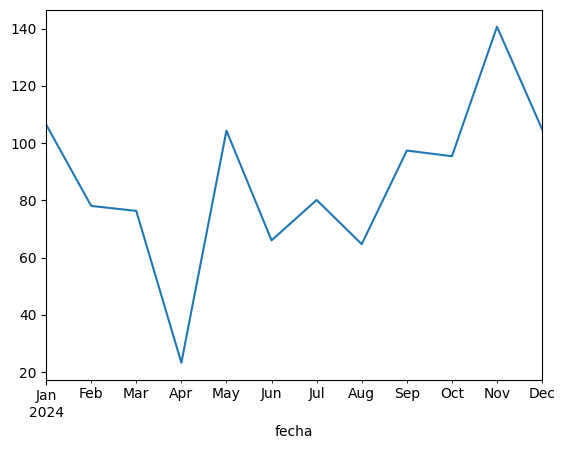

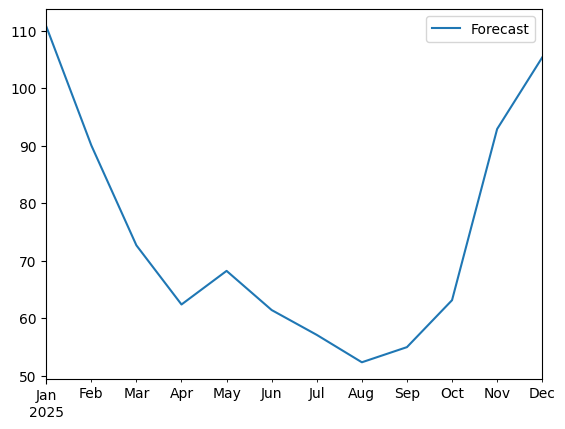

In [82]:
df_prueba['produccion'].plot()
forecast_df_prueba.plot()

<Axes: xlabel='fecha'>

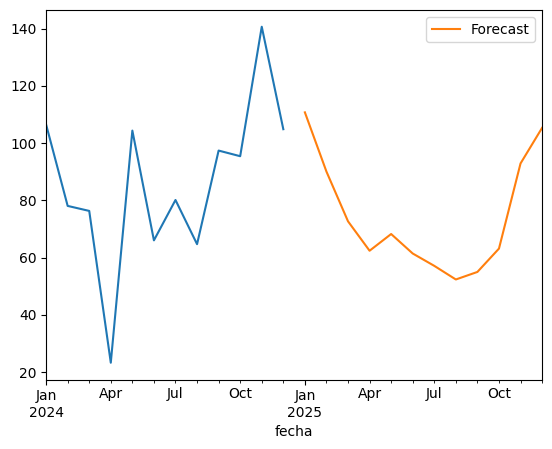

In [83]:
ax = df_prueba['produccion'].plot()
forecast_df_prueba.plot(ax=ax)

(660.0, 663.0)

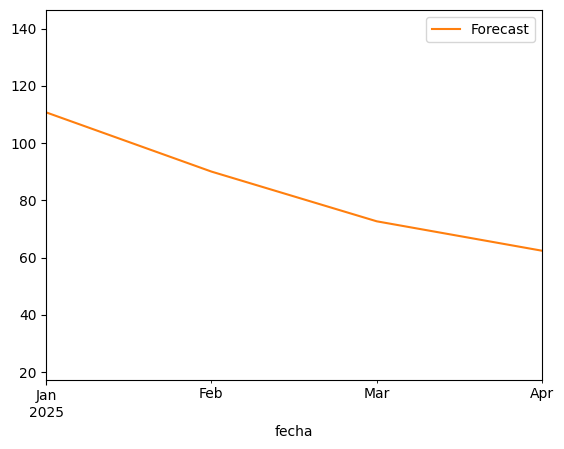

In [84]:
#Hacemos zoom
ax = df_prueba['produccion'].plot()
forecast_df_prueba.plot(ax=ax)
plt.xlim('2025-01-01','2025-04-01')

In [85]:
import joblib

model.save("modelo_forecast.keras")
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [86]:
from tensorflow.keras.models import load_model
modelo = load_model("modelo_forecast.keras")

In [87]:
df_prueba = pd.read_csv(os.path.join(obtener_ruta_app("AgroIA"), "data", "processed", "rnn", "dataset1.csv"),index_col='fecha', parse_dates=True, date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))

C:\Users\pmari\AppData\Local\Temp\ipykernel_20856\2479101291.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_prueba = pd.read_csv(os.path.join(obtener_ruta_app("AgroIA"), "data", "processed", "rnn", "dataset1.csv"),index_col='fecha', parse_dates=True, date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))


In [88]:
df_prueba.head()

,lluvia,humedad,temperatura,produccion
fecha,,,,
2024-01-01,45.23,88.15,19.87,92.34
2024-02-01,89.67,86.92,20.45,85.12
2024-03-01,156.78,84.56,21.23,118.67
2024-04-01,234.89,87.34,22.01,67.89
2024-05-01,678.45,89.78,21.89,125.45


In [89]:
df_prueba = df_prueba[['lluvia', 'humedad', 'temperatura', 'produccion']]
full_scaler_prueba = MinMaxScaler()
scaled_full_data_prueba = full_scaler_prueba.fit_transform(df_prueba)
full_scaler_prueba

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [90]:
scaled_full_data_prueba

array([[0.        , 0.38937093, 0.        , 0.2747191 ],
       [0.05630091, 0.25596529, 0.25550661, 0.19359551],
       [0.14132239, 0.        , 0.59911894, 0.5705618 ],
       [0.24027973, 0.30151844, 0.94273128, 0.        ],
       [0.80222467, 0.56616052, 0.88986784, 0.64674157],
       [0.85881697, 0.72342733, 1.        , 0.11617978],
       [0.52139156, 0.87960954, 0.74449339, 0.31213483],
       [0.33854028, 0.68655098, 0.84140969, 0.4994382 ],
       [0.66215651, 0.7472885 , 0.64757709, 0.24224719],
       [0.50731633, 0.81995662, 0.79295154, 0.40325843],
       [1.        , 1.        , 0.44933921, 1.        ],
       [0.18257256, 0.75921909, 0.15859031, 0.3458427 ]])

In [91]:
forecast = []

periodos = 12 # Indicamos el número de periodos en base a la longitud del forecast deseada (12 meses)

primer_batch = scaled_full_data_prueba[-12:]
batch_actual = primer_batch.reshape((1, 12, 4))

for i in range(periodos):

    pred_actual = modelo.predict(batch_actual)[0]
    forecast.append(pred_actual)

    # Actualizar batch_actual de forma más simple
    batch_actual = np.roll(batch_actual, -1, axis=1)
    batch_actual[0, -1, :] = pred_actual

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [92]:
forecast = np.array(forecast)

# Extraer parámetros de la primera variable del scaler original
min_val = scaler.min_[0]
scale_val = scaler.scale_[0]

# Aplicar inverse transform manualmente
forecast_original = (forecast / scale_val) + min_val

In [93]:
forecast_variable_interes_prueba = forecast_original

In [94]:
forecast_index_prueba = pd.date_range(start='2025-01-01', periods=12, freq='MS')  #MS = Monthly Start
forecast_df_prueba = pd.DataFrame(data=forecast_variable_interes_prueba, index=forecast_index_prueba,
                                  columns=['Forecast'])

<Axes: >

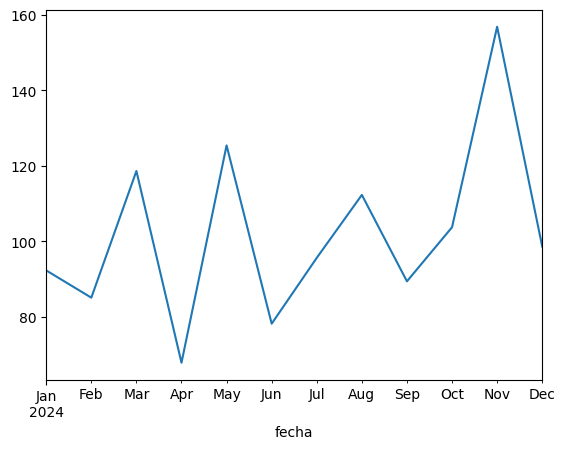

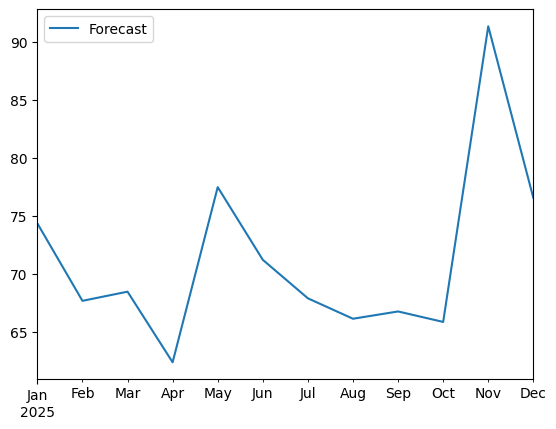

In [95]:
df_prueba['produccion'].plot()
forecast_df_prueba.plot()

<Axes: xlabel='fecha'>

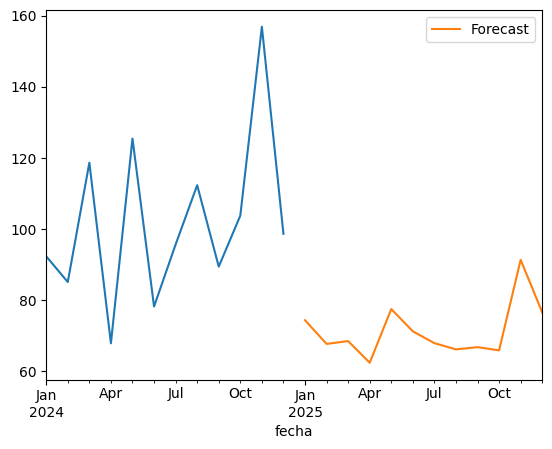

In [96]:
ax = df_prueba['produccion'].plot()
forecast_df_prueba.plot(ax=ax)